# <font color='red'>Clustering Assignment</font>


**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from tqdm import tqdm

In [2]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])


In [3]:
edges = [tuple(x) for x in data.values.tolist()]

In [4]:
edges=[(x,y) for (y,x) in edges]

number of nodes 4703
number of edges 9650


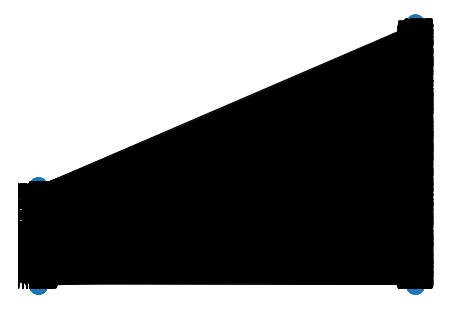

In [5]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')
A = list(nx.connected_component_subgraphs(B))[0]
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [6]:
movies = []
actors = []
for i in B.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [7]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(B))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
    
]

walks = rw.run(nodes=list(B.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [8]:
from gensim.models import Word2Vec
model = Word2Vec(walks, vector_size=128, window=5)

In [9]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [10]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality

In [11]:
actor_nodes=[i for i in node_ids if "a" in i]
movie_nodes=[j for j in node_ids if "m" in j]
len(actor_nodes),len(movie_nodes)

(3411, 1292)

In [12]:
def data_split(node_ids,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    '''First we have taken the node_ids from wv embeddings then tried to get the index of the movie and actor nodes.
    Then with the help of these indices we can find the word embeddings of that node.'''
    nodes_actor=[]
    nodes_movie=[]
    for actor_movie in node_ids:
        if "a" in actor_movie:
            nodes_actor.append(actor_movie)
        else:
            nodes_movie.append(actor_movie)
    movie_indices=[]
    actor_indices=[]
    for actormovie_indices in node_ids:
        if "m" in actormovie_indices:
            movie_indices.append(node_ids.index(actormovie_indices))
        else:
            actor_indices.append(node_ids.index(actormovie_indices))
    actor_embeddings,movie_embeddings=node_embeddings[actor_indices,:],node_embeddings[movie_indices,:]
    return nodes_actor,nodes_movie,actor_embeddings,movie_embeddings

<font color='cyan'>Grader function - 1</font>

In [13]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [14]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [15]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    max_nodes,total_nodes=len(max(nx.connected_components(graph),key=len)),graph.number_of_nodes()
    cost1= max_nodes/(total_nodes)
    return cost1/number_of_clusters

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [16]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    num=0
    den=0
    for i in graph.nodes:
        if "a" in i:
            num+=graph.degree(i)
        else:
            den+=1
    cost2= num/(den)
    return cost2/number_of_clusters

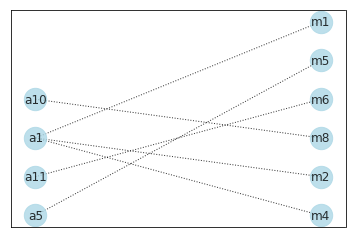

In [17]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {} # it is basically required by the nx.draw to set the position of the graph in the figure, it requires x and the y co-ordinates
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [18]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='cyan'>Grader function - 4</font>

In [19]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

In [20]:
def Kmeans_clustering(nodes,list_num_cluster,embeddings):
    all_cost=[]
    #Running loop for different number of cluster values
    for k in (list_num_cluster):
        kmeans = KMeans(n_clusters=k).fit(embeddings)
        currcost1=0
        currcost2=0
        #Finding cost function for each clusters formed from the above fitting of kmeans
        for i in range(0,k):
            current_nodes=np.array(nodes).reshape(len(nodes),)[kmeans.labels_==i].tolist()
            current_graph=nx.Graph()
            #Creating the graph Cluster
            for j in current_nodes:
                current_graph.add_nodes_from(nx.ego_graph(B,j).nodes)
                current_graph.add_edges_from(nx.ego_graph(B,j).edges())
            currcost1=currcost1+cost1(current_graph,k)
            currcost2=currcost2+cost2(current_graph,k)
        all_cost.append(currcost1*currcost2)
    kmax=list_num_cluster[all_cost.index(max(all_cost))]
    return kmax,all_cost

In [21]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_embeddings)

In [22]:
list_num_cluster=[3, 5, 10, 30, 50, 100, 200, 500]
kmax_actor,score_actor=Kmeans_clustering(actor_nodes,list_num_cluster,actor_embeddings)
for i,j in zip(list_num_cluster,score_actor):
    print("The cost of ",i," number of cluster is ",j)
print("The value of k is ",kmax_actor)

The cost of  3  number of cluster is  3.725575244657303
The cost of  5  number of cluster is  2.888584960475906
The cost of  10  number of cluster is  2.2689389916515634
The cost of  30  number of cluster is  1.7574169111257325
The cost of  50  number of cluster is  1.5670502480239719
The cost of  100  number of cluster is  1.5592628874662784
The cost of  200  number of cluster is  1.8541525553163092
The cost of  500  number of cluster is  1.8470806873477434
The value of k is  3


In [23]:
list_num_cluster=[3, 5, 10, 30, 50, 100, 200, 500]
kmax_movie,score_movie=Kmeans_clustering(movie_nodes,list_num_cluster,movie_embeddings)
for i,j in zip(list_num_cluster,score_movie):
    print("The cost of ",i," number of cluster is ",j)
print("The value of k is ",kmax_movie)

The cost of  3  number of cluster is  8.388011950992288
The cost of  5  number of cluster is  8.16310541178454
The cost of  10  number of cluster is  8.964492415785722
The cost of  30  number of cluster is  12.72315556651753
The cost of  50  number of cluster is  14.725889907703424
The cost of  100  number of cluster is  13.99838405964806
The cost of  200  number of cluster is  12.88256578652694
The cost of  500  number of cluster is  10.32299746739229
The value of k is  50


In [24]:
kmeans = KMeans(n_clusters=kmax_actor, random_state=0).fit(actor_embeddings)

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,n_jobs=-1)
actor_tsne_2d = tsne.fit_transform(actor_embeddings)

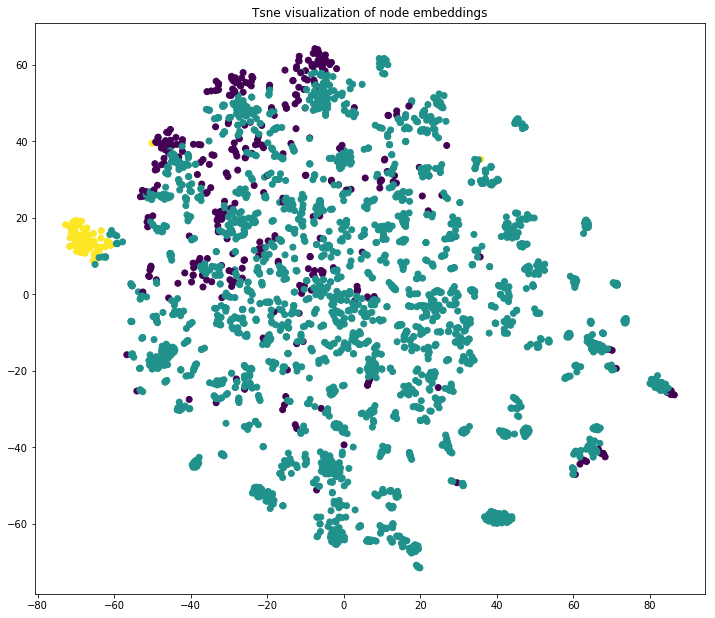

In [26]:
#here we are 
label_map = { l: i for i, l in enumerate(np.unique(list(kmeans.labels_)))}
node_colours = [ label_map[target] for target in list(kmeans.labels_)]
plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")
plt.scatter(actor_tsne_2d[:,0], 
            actor_tsne_2d[:,1], 
            c=node_colours, alpha=1)
plt.title('Tsne visualization of node embeddings')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=kmax_movie, random_state=0).fit(movie_embeddings)

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,n_jobs=-1)
movie_tsne_2d = tsne.fit_transform(movie_embeddings)

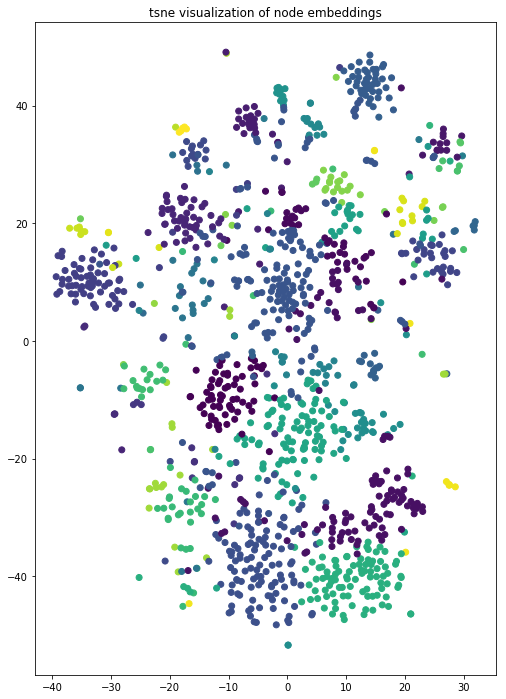

In [29]:
label_map = { l: i for i, l in enumerate(np.unique(list(kmeans.labels_)))}
node_colours = [ label_map[target] for target in list(kmeans.labels_)]
plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")
plt.scatter(movie_tsne_2d[:,0], 
            movie_tsne_2d[:,1], 
            c=node_colours, alpha=1)
plt.title('tsne visualization of node embeddings')
plt.show()